# The recipe for a successful movie

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.stats.weightstats
import sys
import os

sys.path.append(os.path.abspath(os.path.join('src', 'utils')))

import exploratory_analysis
import plotting
import data_cleaning
import data_utils
from exploratory_analysis import *
from plotting import *
from data_cleaning import *
from data_utils import *
from scipy.stats import pearsonr, spearmanr

# ORIGINAL DATASET

First, we will briefly look at the original datasets, and see what can be done to improve their quality.

In [64]:
DATA_FOLDER = "data"

MOVIES_DATASET = DATA_FOLDER+"\movie.metadata.tsv" 
CHARACTERS_DATASET = DATA_FOLDER+"\character.metadata.tsv"

# Dataset loading
movies = pd.read_csv(MOVIES_DATASET, sep='\t', header=None)
characters = pd.read_csv(CHARACTERS_DATASET, sep='\t', header=None)

In [65]:
mapper = {0: 'wikipedia_id',
          1: 'f_id',
          2: 'title',
          3: 'rel_date',
          4: 'revenue',
          5: 'runtime',
          6: 'language',
          7: 'country',
          8: 'genre'
          }

movies = movies.rename(columns=mapper, errors="raise")

print_missing_stats(movies)

Total length: 81741
Ratio of missing wikipedia_id: 0.00
Ratio of missing f_id: 0.00
Ratio of missing title: 0.00
Ratio of missing rel_date: 0.08
Ratio of missing revenue: 0.90
Ratio of missing runtime: 0.25
Ratio of missing language: 0.00
Ratio of missing country: 0.00
Ratio of missing genre: 0.00


Notice that many information that we could use to carry out our analysis are not present. For example, one might be interested in a movie's production company, or some sort of ratings.

In [66]:
mapper = {
    0: "wiki_movie_ID",
    1: "freebase_movie_ID",
    2: "rel_date",
    3: "char_name",
    4: "actor_birth",
    5: "actor_gender",
    6: "actor_height",
    7: "actor_ethnicity_ID",
    8: "actor_name",
    9: "actor_age_rel",
    10: "character_actor_map_ID",
    11: "character_ID",
    12: "actor_ID"
}

characters = characters.rename(mapper=mapper, axis=1)

print_missing_stats(characters)

Total length: 450669
Ratio of missing wiki_movie_ID: 0.00
Ratio of missing freebase_movie_ID: 0.00
Ratio of missing rel_date: 0.02
Ratio of missing char_name: 0.57
Ratio of missing actor_birth: 0.24
Ratio of missing actor_gender: 0.10
Ratio of missing actor_height: 0.66
Ratio of missing actor_ethnicity_ID: 0.76
Ratio of missing actor_name: 0.00
Ratio of missing actor_age_rel: 0.35
Ratio of missing character_actor_map_ID: 0.00
Ratio of missing character_ID: 0.57
Ratio of missing actor_ID: 0.00


Many relevant informations are missing (e.g. actors' places of birth or data about directors).

In order to overcome these issues, we incorporated data from three additional sources: The Movie Database (TMDB), Internet Movie Database (IMDB) and Wikidata. For the first one, we downloaded the data from [Kaggle](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies). For IMDB, we utilized the [IMDB Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/). Lastly, for Wikidata, we wrote a script that utilizes the [Wikidata Query Service](https://query.wikidata.org/) to automatically retrieve extensive information about movies, casts, and related people. The code utilized is contained in the notebook `src/scripts/scrape_wikidata.ipynb`.

We have integrated the MovieSummaries dataset with these additional sources into a unified dataset. The complete integration code is available in the `src/scripts` folder of the repository.

From now on, we will just use the datasets generated at the end of this process.

# DATASET EXPLORATION

In [67]:
DATA_FOLDER = "data"

MOVIES_DATASET = DATA_FOLDER + "\movies_complete.tsv" 
PEOPLE_DATASET = DATA_FOLDER + "\people_complete.tsv"
MOVIE_ACTOR_DATASET = DATA_FOLDER + "\movie_actor_complete.tsv"

# Datasets loading
movies_complete = pd.read_csv(MOVIES_DATASET, sep='\t', header=0, low_memory=False)
people_complete = pd.read_csv(PEOPLE_DATASET, sep='\t', header=0)
movie_actor_complete = pd.read_csv(MOVIE_ACTOR_DATASET, sep='\t', header=0, low_memory=False)

## Movies Dataset

In [68]:
print_missing_stats(movies_complete)

movies_complete.head()

Total length: 79764
Ratio of missing freebase_id_movie: 0.00
Ratio of missing wikidata_id_movie: 0.04
Ratio of missing wikipedia_id_movie: 0.00
Ratio of missing imdb_id_movie: 0.18
Ratio of missing tmdb_id_movie: 0.21
Ratio of missing wikipediaLink: 0.06
Ratio of missing primaryTitle: 0.00
Ratio of missing originalTitle: 0.18
Ratio of missing description_wikidata: 0.04
Ratio of missing release_date: 0.11
Ratio of missing release_year: 0.00
Ratio of missing runtimeMinutes: 0.07
Ratio of missing original_language: 0.21
Ratio of missing languages: 0.03
Ratio of missing countries: 0.01
Ratio of missing genres_original: 0.03
Ratio of missing genres_wikidata: 0.15
Ratio of missing genres_IMDB_TMDB: 0.19
Ratio of missing rating_imdb: 0.23
Ratio of missing numVotes_imdb: 0.23
Ratio of missing budget: 0.88
Ratio of missing revenue: 0.89
Ratio of missing production_companies: 0.32
Ratio of missing overview_tmdb: 0.24
Ratio of missing keywords_tmdb: 0.52


,freebase_id_movie,wikidata_id_movie,wikipedia_id_movie,imdb_id_movie,tmdb_id_movie,wikipediaLink,primaryTitle,originalTitle,description_wikidata,release_date,...,genres_original,genres_wikidata,genres_IMDB_TMDB,rating_imdb,numVotes_imdb,budget,revenue,production_companies,overview_tmdb,keywords_tmdb
0,/m/03vyhn,http://www.wikidata.org/entity/Q261700,975900,tt0228333,10016.0,https://en.wikipedia.org/wiki/Ghosts_of_Mars,Ghosts of Mars,Ghosts of Mars,2001 film by John Carpenter,2001-08-24,...,"thriller,science fiction,horror,adventure,supe...","ghost film,science fiction film,adventure film...","science fiction,sci-fi,action,horror",4.9,58866.0,28000000.0,14010832.0,"Animationwerks,Screen Gems,Storm King Productions","In 2176, a Martian police unit is sent to pick...","future,planet mars,anti hero,possession,hot ai..."
1,/m/08yl5d,http://www.wikidata.org/entity/Q16250726,3196793,tt0245916,784579.0,https://en.wikipedia.org/wiki/Getting_Away_wit...,Getting Away with Murder: The JonBenet Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,2000 television film,2000-02-16,...,"mystery,biographical film,drama,crime drama",biographical film,"drama,crime",6.0,76.0,NaN,NaN,NaN,Dramatization of the story behind the murder o...,"colorado,jonbenet"
2,/m/0crgdbh,http://www.wikidata.org/entity/Q4978832,28463795,tt0094806,396302.0,https://en.wikipedia.org/wiki/Brun_bitter,Brun bitter,Brun bitter,1988 film by Sølve Skagen,1988-11-17,...,"crime fiction,drama",drama film,"drama,crime,mystery",5.6,42.0,NaN,NaN,"Filmeffekt AS,Norsk Film",A stolen bicycle case ends with drunken detect...,"bicycle,private detective"
3,/m/0285_cd,http://www.wikidata.org/entity/Q7995657,9363483,tt0094320,33592.0,https://en.wikipedia.org/wiki/White_of_the_Eye,White of the Eye,White of the Eye,"1987 film by Cassian Elwes, Donald Cammell",1987-06-19,...,"thriller,erotic thriller,psychological thriller","film based on a novel,slasher film","thriller,mystery,horror",6.1,3087.0,NaN,NaN,Mrs. White's Productions,"In a wealthy and isolated desert community, a ...","based on novel or book,gas station,psychopath,..."
4,/m/01mrr1,http://www.wikidata.org/entity/Q869644,261236,tt0083949,11192.0,https://en.wikipedia.org/wiki/A_Woman_in_Flames,A Woman in Flames,Die flambierte Frau,1983 FRG film by Robert van Ackeren,1983-05-11,...,drama,drama film,drama,5.9,648.0,NaN,NaN,Dieter Geissler Filmproduktion,"Eva, an upper-class housewife, frustratedly le...","jealousy,eroticism,gigolo,longing,dominatrix,s..."


Apart from revenues and budget, there are no features with a very large number of missing values. We will try to deal with this after, once we have fully explored our dataset. 

In order to better understand the possible correlations between different features, we plot a scatter matrix.

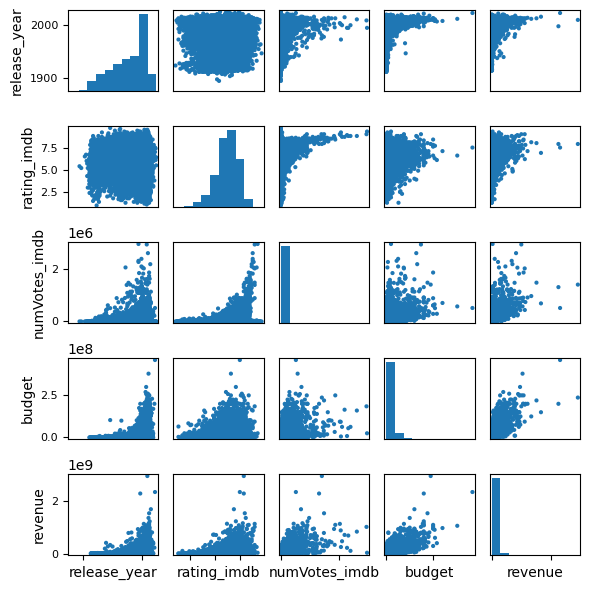

In [69]:
# Features to plot
to_keep = ['release_year', 'runtimeMinutes', 'original_language',
           'genres_original', 'rating_imdb', 'numVotes_imdb',
           'budget', 'revenue']
figsize = (6,6)

plot_scatter_matrix(movies_complete, to_keep, by='include', figsize=figsize)

From the matrix, we notice that some possible correlations exist between the considered variables. However, we cannot clearly see all single distributions; the ones for number of ratings, revenues and budget are unclear: let us inspect them separately.

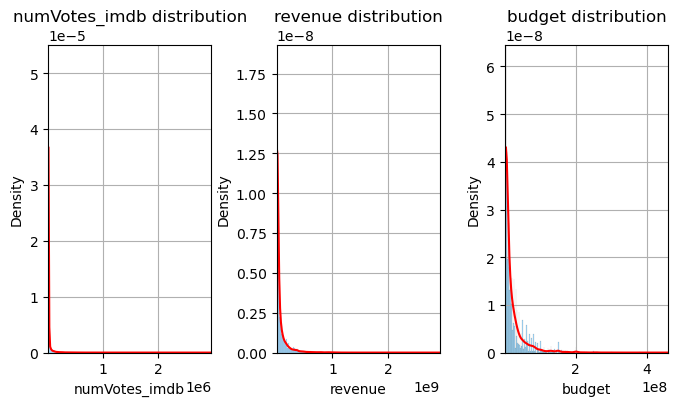

In [70]:
columns = ['numVotes_imdb', 'revenue', 'budget']
nrows = 1
ncols = len(columns)
figsize = (8,4)

plot_histograms(movies_complete, columns, nrows, ncols, figsize)

These distributions are highly skewed: we might take their logarithm and see whether we get more symmetric features.

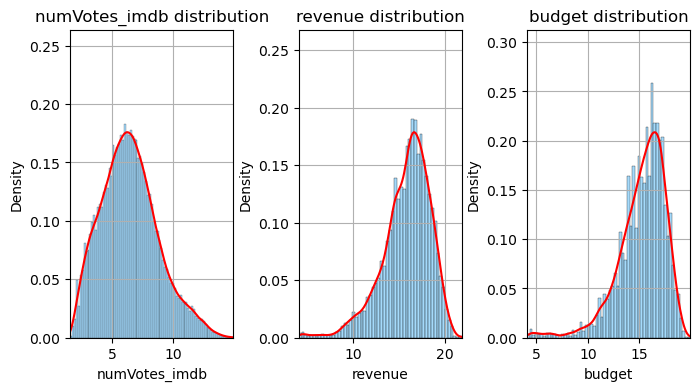

In [72]:
columns = ['numVotes_imdb', 'revenue', 'budget']
nrows = 1
ncols = len(columns)
figsize = (8,4)

df = movies_complete[columns]
df.loc[:,'numVotes_imdb'] = np.log(df['numVotes_imdb'])
df.loc[:,'revenue'] = np.log(df['revenue'])
df.loc[:,'budget'] = np.log(df['budget'])

plot_histograms(df, columns, nrows, ncols, figsize)

It seems better to work with the logarithm of such variables, so we simply replace them with their log in the original dataset.

In [73]:
columns = ['numVotes_imdb', 'revenue', 'budget']

transform_columns(movies_complete, columns, np.log, substitute=True, prefix='log')

Now, since the goal of our analysis is to see what features mostly impact on a movie's success, we have to decide which factors can be considered as indicators for the success. We will use three main metrics:
- Ratings: high ratings can be regarded as positive indicators for a movie's successful outcome, whereas low ones might indicate poor performance;
- Number of ratings: this is a proxy of a movie's popularity (the more ratings, the more the movie has been watched);
- Revenue: the amount of money that the movie generated is important to determine its success.

Let us briefly inspect these features. In particular, we aim at:
1) Analyzing the distribution of ratings, seeing whether these data need some processing or not;
2) Inspecting the correlations among the three variables;
3) Check if we can come up with a resonable way of filling missing data about revenues.

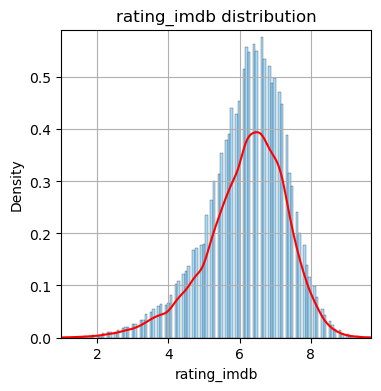

Description of ratings:

count    61331.000000
mean         6.195425
std          1.126128
min          1.000000
25%          5.600000
50%          6.300000
75%          7.000000
max          9.700000
Name: rating_imdb, dtype: float64


In [74]:
# Plot
columns = ['rating_imdb']
nrows = 1
ncols = 1
plot_histograms(movies_complete, columns, nrows, ncols, figsize=(4, 4), scale='normal')

# Print description
print("Description of ratings:\n")
print(movies_complete['rating_imdb'].describe())

The distribution is not particularly skewed; however, we notice that the ratings tend to cluster on a discrete set of values. This suggests that it might be better to regard ratings as a categorical feature, motivated by the fact that probably there is no big difference in the public's feeling towards a movie that has mean rating 7.3 or 7.8 on a 1-10 scale.

In [75]:
columns = ['rating_imdb']
func = np.floor

transform_columns(movies_complete, columns, func, substitute=True, prefix='categorized')

# Print number of observations for each category
for cat in np.sort(movies_complete['categorized_rating_imdb'].dropna().unique()):
    print("Category [", int(cat), ",", int(cat+1), ") contains ",
          (movies_complete['categorized_rating_imdb']==cat).sum(), "values")

Category [ 1 , 2 ) contains  79 values
Category [ 2 , 3 ) contains  526 values
Category [ 3 , 4 ) contains  1964 values
Category [ 4 , 5 ) contains  5485 values
Category [ 5 , 6 ) contains  14271 values
Category [ 6 , 7 ) contains  23043 values
Category [ 7 , 8 ) contains  13774 values
Category [ 8 , 9 ) contains  2109 values
Category [ 9 , 10 ) contains  80 values


We visually inspect the correlations between these variables.

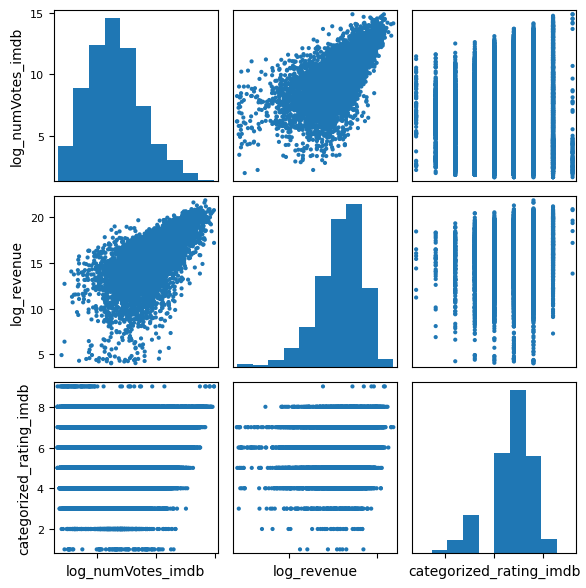

In [76]:
# Features to plot
to_keep = ['log_numVotes_imdb', 'log_revenue', 'categorized_rating_imdb']
figsize = (6,6)

plot_scatter_matrix(movies_complete, to_keep, by='include', figsize=figsize)

We notice a high correlation between the log of revenues and the log of number of ratings: we perform a Pearson test for correlation to be sure.

In [77]:
corr_pearson, p_pearson = pearsonr(movies_complete.dropna(subset=['log_numVotes_imdb', 'log_revenue'])
                                   ['log_numVotes_imdb'], 
                                   movies_complete.dropna(subset=['log_numVotes_imdb', 'log_revenue'])
                                   ['log_revenue'])
statistic_name = 'Pearson correlation'
alpha = 0.05
null_hyp = 'Features are not correlated'
print_tests_results(corr_pearson, p_pearson, statistic_name, null_hyp, alpha)

With a value of 0.67 for Pearson correlation  and a p-value of 0.00, 
we CAN significantly REJECT the null hypothesis (i.e. " Features are not correlated ")


There is significant linear correlation. In fact, we might try to recover missing revenues by performing a linear regression using the number of ratings. It makes sense that the number of received ratings is proportional to the revenues of a movie (here we are talking in terms of their logarithms); moreover, the above result mathematically confirms this intuition.

## People Dataset

In [78]:
print_missing_stats(people_complete)

people_complete.head()

Total length: 194234
Ratio of missing univocal_id_actor: 0.00
Ratio of missing freebase_id_actor: 0.13
Ratio of missing wikidata_id_actor: 0.43
Ratio of missing imdb_id_actor: 0.45
Ratio of missing wikipediaLink_actor: 0.61
Ratio of missing nameSurname_actor: 0.00
Ratio of missing givenName_actor: 0.51
Ratio of missing familyName_actor: 0.60
Ratio of missing gender: 0.19
Ratio of missing date_of_birth: 0.47
Ratio of missing year_of_birth: 0.41
Ratio of missing date_of_death: 0.80
Ratio of missing year_of_death: 0.79
Ratio of missing place_of_birth: 0.53
Ratio of missing citizenship: 0.49
Ratio of missing language: 0.85
Ratio of missing height: 0.93
Ratio of missing freebase_id_etnicity: 0.96


,univocal_id_actor,freebase_id_actor,wikidata_id_actor,imdb_id_actor,wikipediaLink_actor,nameSurname_actor,givenName_actor,familyName_actor,gender,date_of_birth,year_of_birth,date_of_death,year_of_death,place_of_birth,citizenship,language,height,freebase_id_etnicity
0,/m/0100_2df,/m/0100_2df,http://www.wikidata.org/entity/Q20751192,nm6204617,https://en.wikipedia.org/wiki/Vikram_Thakor,Vikram Thakor,Vikram,Thakor,M,NaN,NaN,NaN,NaN,NaN,India,NaN,NaN,NaN
1,/m/0100dynw,/m/0100dynw,http://www.wikidata.org/entity/Q16735031,nm7992272,https://en.wikipedia.org/wiki/Ravichandran_(Ta...,Ravichandran,NaN,NaN,M,1971-03-17,1971.0,NaN,NaN,Tamil Nadu,India,NaN,NaN,NaN
2,/m/0100hh2v,/m/0100hh2v,http://www.wikidata.org/entity/Q6113391,nm0146874,https://en.wikipedia.org/wiki/Rub%C3%A9n_W._Ca...,Rubén W. Cavallotti,Rubén,NaN,M,1923-10-06,1923.0,1999-05-15,1999.0,Montevideo,"Argentina,Uruguay",NaN,NaN,NaN
3,/m/0100nwsn,/m/0100nwsn,http://www.wikidata.org/entity/Q16010327,nm0189759,https://en.wikipedia.org/wiki/Matt_Crowley,Matt Crowley,Matt,Crowley,M,1905-06-20,1905.0,1983-03-07,1983.0,New Haven,United States of America,NaN,NaN,NaN
4,/m/0100qv7r,/m/0100qv7r,http://www.wikidata.org/entity/Q2669110,NaN,https://en.wikipedia.org/wiki/Christine_Jones_...,Christine Jones Forman,Christine,Forman,F,1949-02-03,1949.0,NaN,NaN,Minneapolis,United States of America,NaN,NaN,NaN


Some features have a high number of missing values, but they won't probably impact our analysis (for example, the language or the height).
Let us inspect the distributions of cast members' gender, since it might be important to determine the success of a movie.

Text(0, 0.5, '')

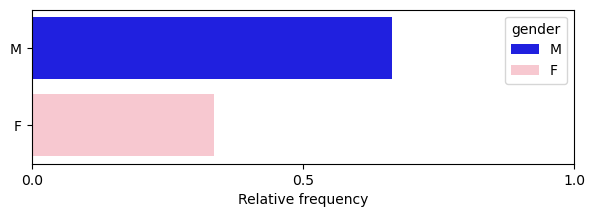

In [79]:
counts = people_complete['gender'].value_counts().reset_index()
counts['count'] = counts['count'] / counts['count'].sum()
plt.subplots(figsize=(7, 2))
sns.barplot(y='gender', x='count', data=counts, palette=['blue', 'pink'], hue='gender', legend=True)
plt.xticks([0, 0.5, 1])
plt.xlabel('Relative frequency')
plt.ylabel('')

We notice a predominance of males in the industry.

It might make sense to extract the age of an actor/director at the movie release. This is because the experience of the cast might be a good indicator of the movie's performance. To do this, we need to merge the dataset of movies with the one of people.

In [80]:
pivot_df = movie_actor_complete
cast_df = people_complete
movies_df = movies_complete
cast_key_pivot = 'freebase_id_actor'
cast_key_right = 'freebase_id_actor'
movie_key_pivot = 'freebase_id_movie'
movie_key_right = 'freebase_id_movie'
columns = ['freebase_id_movie', 'freebase_id_actor', 'year_of_birth', 
'release_year', 'log_numVotes_imdb','categorized_rating_imdb']
role_col = 'role'

movies_and_cast = merge_movies_cast(pivot_df, cast_df, movies_df, 
                      cast_key_pivot, cast_key_right, movie_key_pivot, 
                      movie_key_right, columns, role_col, role='any')

movies_and_cast = compute_age(movies_and_cast, 'year_of_birth', 'release_year', 'age_at_release')

print_missing_stats(movies_and_cast)

movies_and_cast.head()

Total length: 541827
Ratio of missing freebase_id_movie: 0.00
Ratio of missing freebase_id_actor: 0.00
Ratio of missing year_of_birth: 0.04
Ratio of missing release_year: 0.00
Ratio of missing log_numVotes_imdb: 0.10
Ratio of missing categorized_rating_imdb: 0.10
Ratio of missing age_at_release: 0.09


,freebase_id_movie,freebase_id_actor,year_of_birth,release_year,log_numVotes_imdb,categorized_rating_imdb,age_at_release
0,/m/0bmjls,/m/0c3yhsk,1922.0,1962,7.360104,5.0,40.0
1,/m/0bmjls,/m/0c8wy4,1907.0,1962,7.360104,5.0,55.0
3,/m/0bmjls,/m/055l9cb,1903.0,1962,7.360104,5.0,59.0
4,/m/03gqvmb,/m/01tz8h,1919.0,1950,6.502790,5.0,31.0
5,/m/03gqvmb,/m/04xqk0,1928.0,1950,6.502790,5.0,22.0


We notice that for the age at release the ratio of missing values is negligible: we can just leave it, and drop it in case missing values may create issues with the analysis.

# FIRST ANALYSIS

Now that we have explored the starting datasets, we will try some initial analysis to understand whether there is margin for extracting relevant information about what makes a movie successful. We will mainly focus on how particular features can be descriptive of the positive ratings, number of ratings and revenues for a movie, sometimes considering one success metric, sometimes another, in order to explore different possibilities.

The following part of the notebook will be motivated by the following two research questions:

1) How much is the age of actors appearing in a movie relevant for its success? On one hand, an old actor might be more experienced and famous, so he/she might be better at acting and might attract watchers by the only power of his/her fame; On the other hand, young people might prefer 'seeing themselves' on the screen, and even an older public can be more attracted by young actors' novelty.
2) What is the impact of the producing company on the popularity of the movie? There is the possibility that, as it happens in many other artistic works (e.g. songs), people regard a successful producer as a warranty of quality. However, it might happen that little companies are more free in their works, being less constrained by heavy obligations due to investors, politics,...

## 1) Actors'ages

In order to answer to the question, we consider ratings categories as a metric for success.

As we did above, we create a dataset containing the age at movie release of the actors who played it. Then we group by movie and compute the average age of actors starring in each movie. 

In [81]:
pivot_df = movie_actor_complete
cast_df = people_complete
movies_df = movies_complete
cast_key_pivot = 'freebase_id_actor'
cast_key_right = 'freebase_id_actor'
movie_key_pivot = 'freebase_id_movie'
movie_key_right = 'freebase_id_movie'
columns = ['freebase_id_movie', 'freebase_id_actor', 'year_of_birth', 
'release_year','categorized_rating_imdb']
role_col = 'role'

movies_mean_age = merge_movies_cast(pivot_df, cast_df, movies_df, 
                      cast_key_pivot, cast_key_right, movie_key_pivot, 
                      movie_key_right, columns, role_col, role='any')

movies_mean_age = compute_age(movies_mean_age, 'year_of_birth', 'release_year', 'age_at_release')

movies_mean_age = movies_mean_age.dropna(subset = 'age_at_release')

movies_mean_age = movies_mean_age.groupby('freebase_id_movie').agg({'age_at_release': 'mean'}).reset_index()

movies_mean_age = pd.merge(movies_mean_age, movies_complete[['freebase_id_movie', 'categorized_rating_imdb']])

Now, the question we asked can be rephrased as: is there any significant difference in the average age of actors starring in a movie depending on the movies' final rating? 
To answer, we perform the four following steps:
1) Plot the distribution of ages for different categories;
3) Perform Spearman's independence tests among all couples of close categories, to ensure independence among the two distributions;
4) Perform Z-tests to check difference in averages among categories, which can be done since the size of samples are big, thus Central Limit Theorem holds.

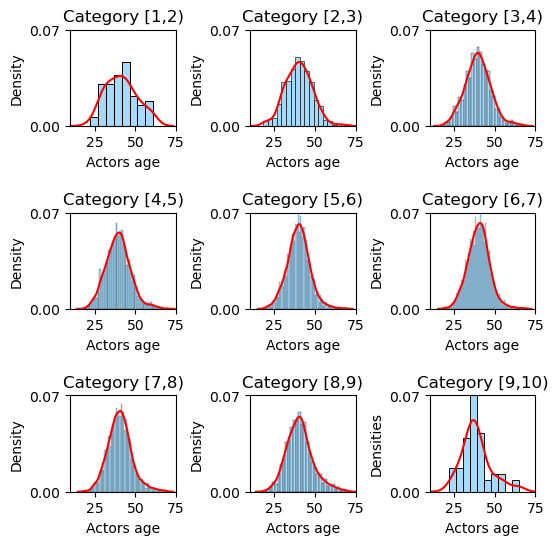

In [82]:
column = 'categorized_rating_imdb'
nrows = 3
ncols = 3
feature = 'age_at_release'
figsize = (6, 6)

plot_histograms_by_category(movies_mean_age, column, nrows, ncols, feature, figsize=figsize)

Let us perform Spearman's correlation tests:

In [83]:
for cat in range(1,9):
    data1 = movies_mean_age[movies_mean_age['categorized_rating_imdb']==cat]['age_at_release']
    data2 = movies_mean_age[movies_mean_age['categorized_rating_imdb']==cat+1]['age_at_release']
    # Perform bootstrapping to have equal length vectors for the test
    data1, data2 = bootstrap(data1, data2)
    corr_spear, p_spear = spearmanr(data1, data2)
    cat_str1 = '[' + str(int(cat)) + ',' + str(int(cat+1)) + ')'
    cat_str2 = '[' + str(int(cat+1)) + ',' + str(int(cat+2)) + ')'
    print("Results for", cat_str1, "and", cat_str2, ":")
    print_tests_results(corr_spear, p_spear, 'Spearman correlation', 
                        'The two datasets are not linearly correlated', alpha=0.05)
    print("\n")

Results for [1,2) and [2,3) :
With a value of -0.01 for Spearman correlation  and a p-value of 0.83, 
we CANNOT significantly REJECT the null hypothesis (i.e. " The two datasets are not linearly correlated ")


Results for [2,3) and [3,4) :
With a value of 0.01 for Spearman correlation  and a p-value of 0.83, 
we CANNOT significantly REJECT the null hypothesis (i.e. " The two datasets are not linearly correlated ")


Results for [3,4) and [4,5) :
With a value of 0.03 for Spearman correlation  and a p-value of 0.04, 
we CAN significantly REJECT the null hypothesis (i.e. " The two datasets are not linearly correlated ")


Results for [4,5) and [5,6) :
With a value of -0.01 for Spearman correlation  and a p-value of 0.31, 
we CANNOT significantly REJECT the null hypothesis (i.e. " The two datasets are not linearly correlated ")


Results for [5,6) and [6,7) :
With a value of 0.00 for Spearman correlation  and a p-value of 0.59, 
we CANNOT significantly REJECT the null hypothesis (i.e. " T

Since every couple of distributions cannot be said to be significantly correlated (nor independent, since dependence implies correlation), we can proceed with the Z-test (the only case where we have correlations produces a very low Spearman correlation coefficient of 0.03).

In [93]:
for cat in range(1,9):
    data1 = movies_mean_age[movies_mean_age['categorized_rating_imdb']==cat]['age_at_release']
    data2 = movies_mean_age[movies_mean_age['categorized_rating_imdb']==cat+1]['age_at_release']
    # Perform bootstrapping to have equal length vectors for the test
    data1, data2 = bootstrap(data1, data2)
    corr_pearson, p_pearson = pearsonr(data1, data2)
    zstat, pval = statsmodels.stats.weightstats.ztest(
                    data2, data1, value=0, 
                    alternative='two-sided', usevar='pooled')
    cat_str1 = '[' + str(int(cat)) + ',' + str(int(cat+1)) + ')'
    cat_str2 = '[' + str(int(cat+1)) + ',' + str(int(cat+2)) + ')'
    print("Results for", cat_str1, "and", cat_str2, ":")
    print_tests_results(zstat, pval, 'Z statistic', 
                        'There is no difference in the two means', alpha=0.05)
    print("\n")

Results for [1,2) and [2,3) :
With a value of -2.28 for Z statistic  and a p-value of 0.02, 
we CAN significantly REJECT the null hypothesis (i.e. " There is no difference in the two means ")


Results for [2,3) and [3,4) :
With a value of -0.42 for Z statistic  and a p-value of 0.68, 
we CANNOT significantly REJECT the null hypothesis (i.e. " There is no difference in the two means ")


Results for [3,4) and [4,5) :
With a value of -0.16 for Z statistic  and a p-value of 0.87, 
we CANNOT significantly REJECT the null hypothesis (i.e. " There is no difference in the two means ")


Results for [4,5) and [5,6) :
With a value of 4.94 for Z statistic  and a p-value of 0.00, 
we CAN significantly REJECT the null hypothesis (i.e. " There is no difference in the two means ")


Results for [5,6) and [6,7) :
With a value of 5.08 for Z statistic  and a p-value of 0.00, 
we CAN significantly REJECT the null hypothesis (i.e. " There is no difference in the two means ")


Results for [6,7) and [7,8

We can notice that there is not a clear trend in the average age of actors while changing rating category: sometimes by increasing the rating we have a significant increase in average age (positive Z-test values), sometimes we have an increase, whereas in some cases we don't even have any significant change. This might mean that actors age cannot alone explain movie's success in terms of positive ratings, and it may be necessary to consider more features.

However, a more thorough analysis has to be carried out:
- ensuring there is a significant difference of averages among all categories (e.g. by performing an ANOVA test)
- performing a classification useful for interpreting the strength of the correlation between the two considered variables

# 2) Production Companies

In this case, we will base our understanding of a movie's success on its popularity, measured as the number of reviews it received (to be precise, its logarithm, by what we said in the data preprocessing section).

Since in many cases the format for the production company has two or more names, we extract the first one to be the primary one. Indeed, in many cases the two names are simply of the kind: production company, spinoff of the same company, so it makes sense to extract the first one.
We do this by calling extract_primary_company(), that returns the dataset with observations sorted by decreasing frequency of the primary production company.

In [94]:
column = 'production_companies'
columns = ['log_numVotes_imdb']
df_companies = extract_primary_company(movies_complete, column, columns, n=20)
df_companies.head()

,log_numVotes_imdb,primary_production_companies,count
5702,8.305978,Metro-Goldwyn-Mayer,1617
6792,6.526495,Metro-Goldwyn-Mayer,1617
1325,9.171080,Metro-Goldwyn-Mayer,1617
4785,7.518607,Metro-Goldwyn-Mayer,1617
1323,8.355145,Metro-Goldwyn-Mayer,1617


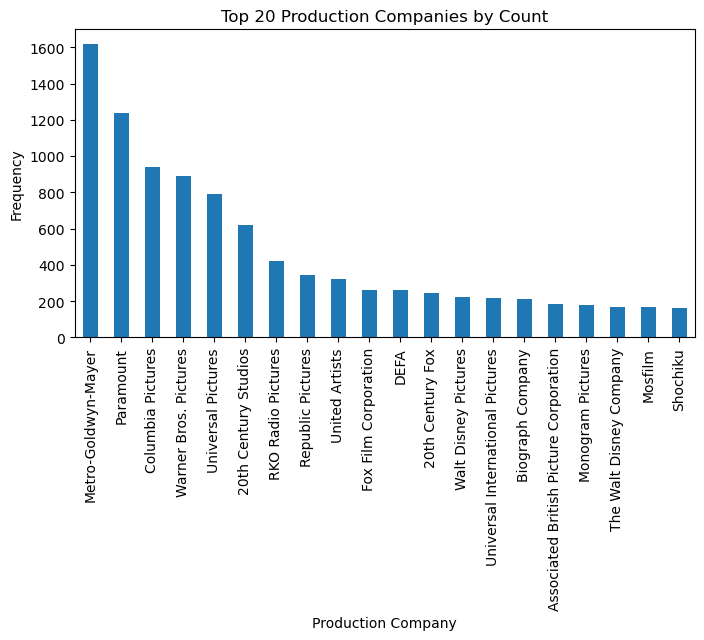

In [95]:
df_companies_sorted = df_companies.groupby('primary_production_companies').head(1).reset_index()

plt.figure(figsize=(8, 4))
df_companies_sorted['count'].plot(kind='bar')
plt.title('Top 20 Production Companies by Count')
plt.xlabel('Production Company')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(df_companies_sorted['primary_production_companies'])), 
           labels=df_companies_sorted['primary_production_companies'])
plt.show()

We observe that the movie industry is dominated by the presence of big companies producing much more movies than the rest (e.g. Metro-Goldwyn-Mayer, Paramount,...).

For the top ten of these, let us find the average popularity of produced movies, measured as number of ratings (actually, log of number of ratings), by exploiting the distributions' boxplots. 

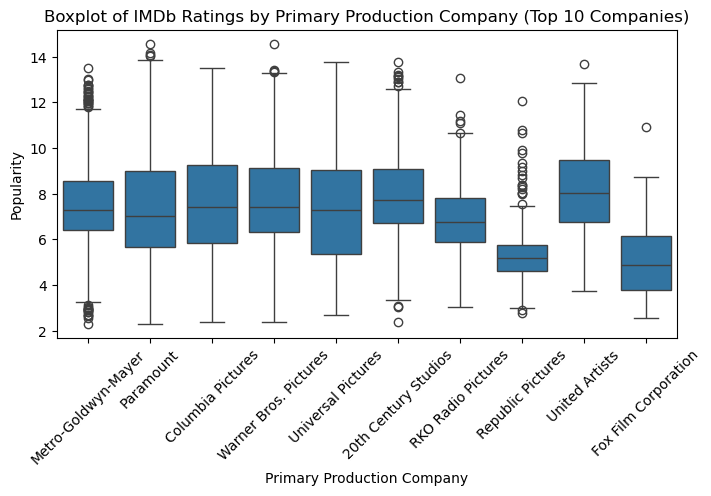

In [96]:
column = 'production_companies'
columns = ['log_numVotes_imdb']
df_companies = extract_primary_company(movies_complete, column, columns, n=10)

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_companies, x='primary_production_companies', y='log_numVotes_imdb')
plt.xticks(rotation=45)
plt.title('Boxplot of IMDb Ratings by Primary Production Company (Top 10 Companies)')
plt.xlabel('Primary Production Company')
plt.ylabel('Popularity')
plt.show()

Here we cannot see any clear trend in the pupularity, which, at least for the ten most productive companies, is not heavily influenced by the production. 

Let us inspect through a barplot how the popularity is distributed among the most "popular" production companies (i.e. the ones producing the most popular movies on average).

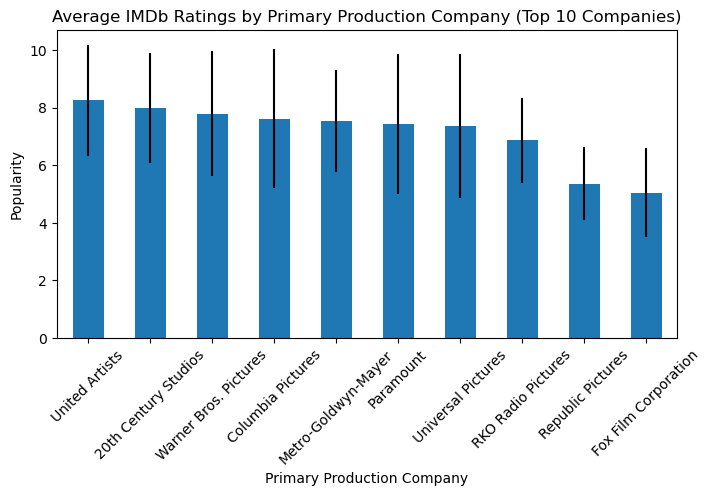

In [97]:
df_companies['std'] = df_companies['log_numVotes_imdb']
avg_popularity = df_companies.groupby('primary_production_companies').agg({'log_numVotes_imdb': 'mean', 'std': 'std'}).reset_index()
avg_popularity = avg_popularity.sort_values(by='log_numVotes_imdb', ascending=False)

plt.figure(figsize=(8, 4))
avg_popularity['log_numVotes_imdb'].plot(kind='bar', yerr=avg_popularity['std'])
plt.title('Average IMDb Ratings by Primary Production Company (Top 10 Companies)')
plt.xlabel('Primary Production Company')
plt.ylabel('Popularity')
plt.xticks(ticks=range(len(avg_popularity['primary_production_companies'])), labels=avg_popularity['primary_production_companies'], rotation=45)
plt.show()

Even though the average popularity seems to be stable for the first seven companies, for all of them we have very high variances, so we cannot significantly conclude what the real trend is. 

Finally, we can try to have a whole view by using a scatterplot comparing the company's importance (in terms of produced movies) in the industry with the average popularity of the movies (i.e. log(number of ratings)). Being the importances of companies very unbalanced, we opt for a log transformation.

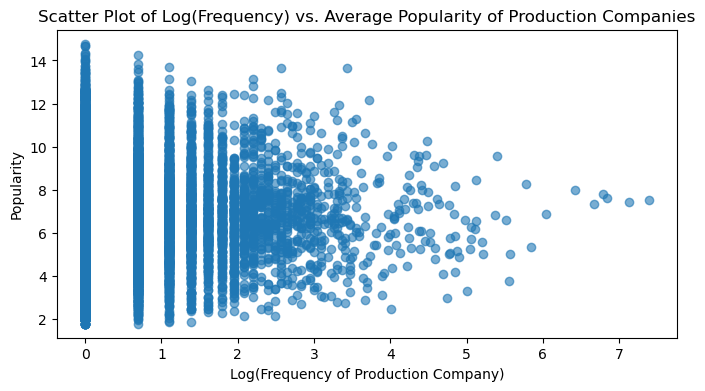

In [98]:
column = 'production_companies'
columns = ['log_numVotes_imdb']
df_companies = extract_primary_company(movies_complete, column, columns, n=0, add_count=True)
df_companies = df_companies.groupby('primary_production_companies').agg({'count': 'first', 'log_numVotes_imdb': 'mean'}).reset_index()
df_companies['log_frequency'] = np.log(df_companies['count'])  


plt.figure(figsize=(8, 4))
plt.scatter(df_companies['log_frequency'], df_companies['log_numVotes_imdb'], alpha=0.6)
plt.title('Scatter Plot of Log(Frequency) vs. Average Popularity of Production Companies')
plt.xlabel('Log(Frequency of Production Company)')
plt.ylabel('Popularity')
plt.show()

This pattern suggests that high-frequency companies tend to produce movies with more stable and moderate average popularity, while low-frequency companies have a broader spectrum of reviews' number. There might be different possible interpretations for this. For example, it might happen that companies producing few movies stick to one pasrticular, successful, genre (or, vice-versa, they have produced a few unpopular movies due to a wrong choice of genre). For sure, this has to be investigated more in the following analysis.